## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from conf_mat import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
from keras import regularizers
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys
import os
import pandas as pd
import librosa
import glob 

Using TensorFlow backend.


In [2]:
#!pip install librosa
# import gzip
# import pickle
# with gzip.open('speech_emotion_data.pkl', 'rb') as ifp:
#     df = pickle.load(ifp)

# Creating set of paths of audio files with corresponding labels

In [3]:
emotion_map = {"01":"Neutral","02":"Calm","03":"Happy","04":"Sad","05":"Angry",
                "06":"Fearful","07":"Disgust","08":"Surprised"}


In [4]:
base_path_audio_files_speech = "/home/atul/ML/Audio_Emotion/Audio_Speech_Actors_01-24"
sub_dirs = os.listdir(base_path_audio_files_speech)
all_data_path = []
all_data_labels = []
for sub_dir in sub_dirs:
    sub_dir_path = base_path_audio_files_speech+"/"+sub_dir
    all_data_path.extend([sub_dir_path+"/"+file for file in os.listdir(sub_dir_path)])
    all_data_labels.extend([emotion_map[file.split("-")[2]] for file in os.listdir(sub_dir_path)])
base_path_audio_files_song = "/home/atul/ML/Audio_Emotion/Audio_Song_Actors_01-24 "
sub_dirs = os.listdir(base_path_audio_files_song)
for sub_dir in sub_dirs:
    sub_dir_path = base_path_audio_files_song+"/"+sub_dir
    all_data_path.extend([sub_dir_path+"/"+file for file in os.listdir(sub_dir_path)])
    all_data_labels.extend([emotion_map[file.split("-")[2]] for file in os.listdir(sub_dir_path)])

## Plotting the audio file's waveform and its spectrogram

In [5]:
data, sampling_rate = librosa.load(all_data_path[0])

Populating the interactive namespace from numpy and matplotlib


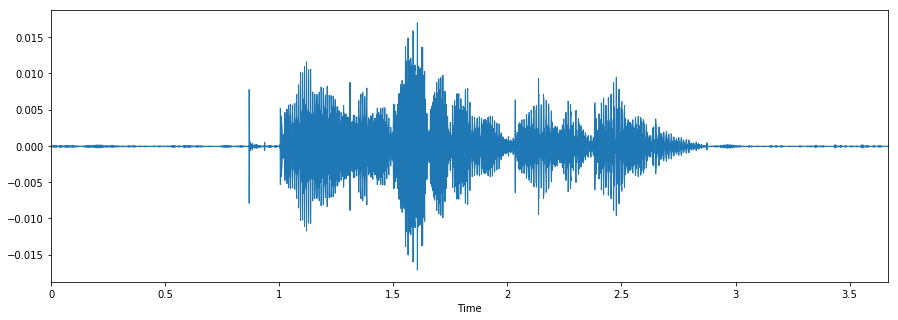

In [6]:
% pylab inline

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/home/atul/anaconda3/envs/my_env35/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


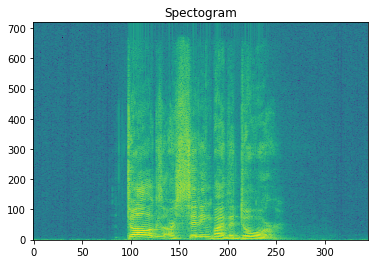

In [7]:
sr,x = scipy.io.wavfile.read(all_data_path[10])

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.title("Spectogram")
plt.show()

## Setting the labels

In [8]:
labels = pd.DataFrame(all_data_labels)

In [9]:
labels[:10]

,0
0,Calm
1,Fearful
2,Calm
3,Fearful
4,Sad
5,Sad
6,Surprised
7,Angry
8,Disgust
9,Sad


## Getting the mfcc features from audio and data preparation

In [10]:
def wav2mfcc(file_path, max_len=72):
    """
    Using librosa to extract mfcc features from audio
    """
    wave, sr = librosa.load(file_path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr)
    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]    
    return mfcc

In [11]:
Data = []
for path in all_data_path:
    mfcc_feat = wav2mfcc(path)    
    Data.append(mfcc_feat)
Data = np.array(Data)

In [12]:
one_hot_label = pd.get_dummies(labels)

In [13]:
one_hot_label.head()

,0_Angry,0_Calm,0_Disgust,0_Fearful,0_Happy,0_Neutral,0_Sad,0_Surprised
0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0


In [14]:
idx = np.arange(Data.shape[0])

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test,train_idx, test_idx = train_test_split(
Data,one_hot_label.values ,idx, test_size=0.20, random_state=42)

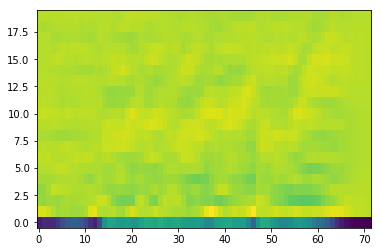

In [16]:
plt.imshow(np.squeeze(X_train[5]), interpolation='nearest',
    origin='lower',
    aspect='auto')

In [17]:
X_train=np.expand_dims(X_train, axis=-1)
X_test= np.expand_dims(X_test, axis=-1)

In [18]:
X_train.shape

(1961, 20, 72, 1)

# Defining model architecture 

In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(20, 72, 1)))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))
model.load_weights('Speech_model_2d.h5')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 19, 71, 32)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 70, 48)        6192      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 69, 120)       23160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 34, 120)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 34, 120)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32640)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4178048   
__________

# Model training and checkpointing best models

In [21]:
# checkpointer = ModelCheckpoint(filepath='Speech_model_2d.h5', verbose=1, save_best_only=True,monitor="val_acc")
# cnnhistory=model.fit(X_train/750,y_train, batch_size=16, epochs=50, validation_data=(X_test/750, y_test),
#                      callbacks=[checkpointer])

# Plotting loss curves for training and validation loss

In [22]:
# plt.plot(cnnhistory.history['loss'])
# plt.plot(cnnhistory.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Prediction and Evaluation of model

In [23]:
probs = model.predict(X_test/750, 
                         batch_size=16, 
                         verbose=1)

491/491 [==============================] - 1s 2ms/step


In [24]:
preds=probs.argmax(axis=1)

In [25]:
true_y = y_test.argmax(axis=1)

In [26]:
Accuracy = np.mean(preds==true_y)
Accuracy

0.7311608961303462

In [27]:
list(one_hot_label.columns)

['0_Angry',
 '0_Calm',
 '0_Disgust',
 '0_Fearful',
 '0_Happy',
 '0_Neutral',
 '0_Sad',
 '0_Surprised']

In [28]:
emotion_map_pandas = {"1":"Calm","2":"Disgust","3":"Fearful","4":"Happy","5":"Neutral",
                "6":"Sad","0":"Angry","7":"Surprised"}


In [29]:
cm = confusion_matrix(pd.Series(true_y).map(str).map(emotion_map_pandas),pd.Series(preds).map(str).map(emotion_map_pandas))

Confusion matrix, without normalization


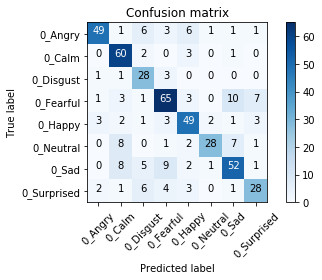

In [30]:
plot_confusion_matrix(cm,classes=list(one_hot_label.columns))

# Plotting ROC curves and auc values

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 8
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

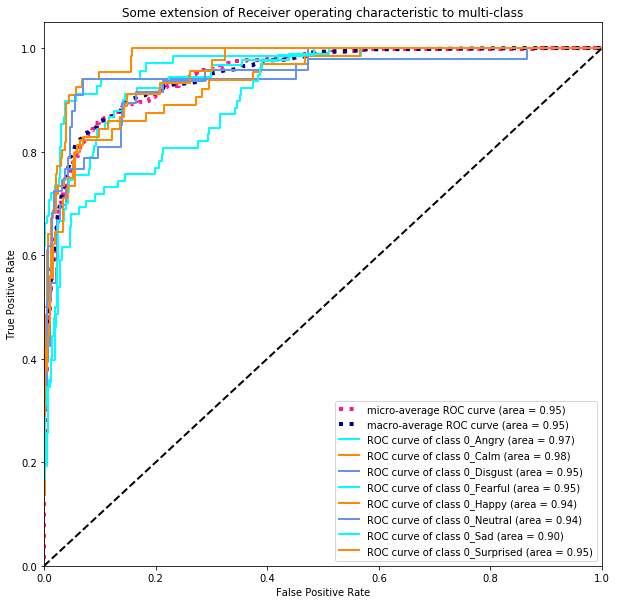

In [32]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(one_hot_label.columns[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Audio Emotion Detection Demo

In [33]:
def emotion_from_audio(path_audio):
    """
    predicts emotion from audio
    """
    mfcc = wav2mfcc(path_audio, max_len=72)
    mfcc_expand_scaled = np.expand_dims(np.expand_dims(mfcc,0),-1)/750
    prediction = model.predict(mfcc_expand_scaled)
    return prediction

### Use utility function below to get set of audio files with particular emotion

In [1]:
def get_audio_list_emotion(emotion):
    """
    returns file list with particular emotion from test data
    """
    index_emotion = np.where(np.array(all_data_labels)==emotion)
    index_emotion_test = list(set(test_idx) & set(np.squeeze(index_emotion)))
    return np.array(all_data_path)[index_emotion_test]
get_audio_list_emotion("Calm")

# Enter audio_path here to test the model

In [45]:
path = '/home/atul/ML/Audio_Emotion/Audio_Song_Actors_01-24 /Actor_13/03-02-02-01-02-01-13.wav'
predictions = emotion_from_audio(path)
predictions_class = emotion_map_pandas[str(predictions.argmax(axis=1)[0])]
predictions_class

'Calm'

In [46]:
ipd.Audio(path)